In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec

import sympy as sp
from matplotlib import cm
from sympy import symbols, diff
from scipy.optimize import root
from joblib import Parallel, delayed
import pickle

# Figure 5

Figure 5A

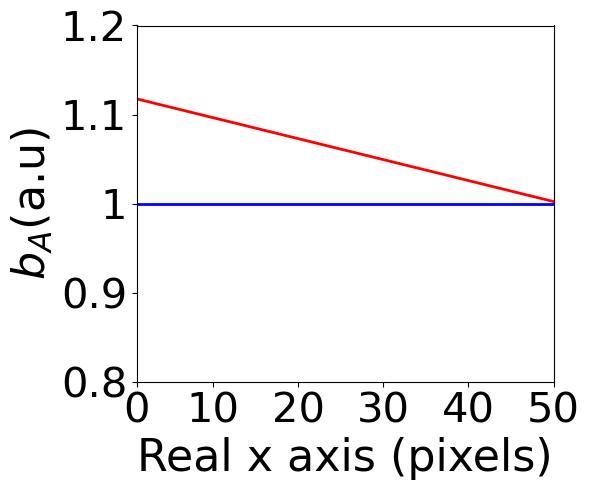

In [31]:
plt.figure(figsize=(6,5))
xvals = np.linspace(1,51,50)
width, height = 50, 50
C0 = 0.12
x = ((np.arange(width))/50)[::-1]
gradient_1D = C0 *x  +1
gradient_2D = np.tile(gradient_1D, (height, 1))
plt.plot(xvals,gradient_1D , color = 'red', linewidth = 2)
width, height = 50, 50
C0 = 0.00
x = ((np.arange(width))/50)[::-1]
gradient_1D = C0 *x  +1
gradient_2D = np.tile(gradient_1D, (height, 1))
plt.plot(xvals, gradient_1D, color = 'blue', linewidth = 2)
plt.xlabel('Real x axis (pixels)', fontsize = 32)
plt.ylabel(r'$b_A$(a.u)', fontsize =32)

plt.xlim(1,50)
plt.xticks(
    ticks=[1,10,20,30,40,50],   # positions
    labels=[0, 10,20,30,40, 50],         # your desired labels
    fontsize=30
)
plt.yticks(ticks=[0.8,0.9,1,1.1,1.2],labels=[0.8,0.9,1,1.1,1.2],fontsize=30)
plt.ylim(0.80,1.2)
plt.tight_layout()
plt.savefig("Images_for_paper/fig5_setup.png")
plt.show()


# Steady state solvers and approximators
The follwoing contains the steady state solver and the approximator for pattern formation. The details of this can be found in the supplementary information. 

In [ ]:
def simulate_TP_LC_same_traj(
    y0, t0, t_max, dt, c, dx, bound_cond, modelfuns, r,
    noise_amp, v_r, v_theta, cent_cyc, k1_0, k2_0,tangential_noise, radial_noise, FF_data,nx,ny
): #This simulates a condition with and without the French flag gradient, both under exact same noised trajectory.
    def apply_boundary(u):
        if bound_cond == 'Neumann':
            u[:, 0] = u[:, 1]
            u[:, -1] = u[:, -2]
            u[0, :] = u[1, :]
            u[-1, :] = u[-2, :]
        elif bound_cond == 'Absorbing':
            u[:, 0] = 0
            u[:, -1] = 0
            u[0, :] = 0
            u[-1, :] = 0
        elif bound_cond == 'Periodic':
            u[:, 0] = u[:, -2]
            u[:, -1] = u[:, 1]
            u[0, :] = u[-2, :]
            u[-1, :] = u[1, :]
        elif bound_cond == 'Vert_periodic':
            u[:, 0] = u[:, 1]         # left edge = next-to-left
            u[:, -1] = u[:, -2]       # right edge = next-to-right
            u[0, :] = u[-2, :]        # top row = second-to-last row
            u[-1, :] = u[1, :]        # bottom row = second row
            
        return u

    def laplacian(u):
        u = apply_boundary(u)
        return (
            -4 * u +
            np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) +
            np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1)
        ) / dx**2
    
    b_a, v_a, k_a,a_conc,b_conc, k_ba, mu_a = symbols('b_a v_a k_a a_conc b_conc k_ba mu_a', real=True)
    r_d_a = b_a + v_a * 1 / (1 + (k_a / a_conc) ** 2) * 1 / (1 + (b_conc / k_ba) ** 2) - mu_a * a_conc
    b_b, v_b, k_ab,a_conc,b_conc, mu_b = symbols('b_b v_b k_ab a_conc b_conc mu_b', real=True)
    r_d_b = b_b + v_b * 1 / (1 + (k_ab / a_conc) ** 2) - mu_b * b_conc
    r_d_a_a = diff(r_d_a, a_conc)
    r_d_a_b = diff(r_d_a, b_conc)
    r_d_b_b = diff(r_d_b, b_conc)
    r_d_b_a = diff(r_d_b, a_conc)
    # Setup initial conditions
    #n = int(np.sqrt(len(y0[:-2]) // 2))  # infer grid size
    params = c
    mod_pars = params[2:]
    ss1 = solve_ss(k1_0,k2_0,params)[0]
    ss2 = solve_ss(k1_0,k2_0,params)[1]
    ss_1 = solve_ss2(k1_0,k2_0,params,[ss1,ss2])[0]
    ss_2 = solve_ss2(k1_0,k2_0,params,[ss1,ss2])[1]
    a = np.reshape(np.zeros(nx*ny) + float(ss_1),(nx,ny))
    b = np.reshape(np.zeros(nx*ny) + float(ss_2),(nx,ny)) 
    a2 = a.copy()
    b2 = b.copy()

    k1 = k1_0
    k2 = k2_0
    t = t0
    Da = params[0]
    Db = params[1]
    values_base = { v_a: mod_pars[0], k_ba: mod_pars[2], mu_a: mod_pars[5],
        b_b: mod_pars[4], v_b: mod_pars[1], mu_b: mod_pars[6] # Fixed values
    }
    k_values = np.linspace(0, 2, 100)
    results = []  # List to store time, concentrations, and rate constants
    n = 0
    while t < t_max:
        a = apply_boundary(a)
        b = apply_boundary(b) 
        a2 = apply_boundary(a2)
        b2 = apply_boundary(b2) 
        
        # A compromise as the compution time is too long if we check turing every dt. so we check evert 1 t.
        # if int(n % (1/dt)) == 0:
        #     unique_regions = np.unique(FF_data)
        #     FF_trig = 0  # default to off
        #     for region_val in unique_regions:
        #         values = values_base.copy()
        #         params2 = params
        #         params2[5] = mod_pars[3] + region_val
        #         # Boost b_a for this region
        #         values[k_a] = k1
        #         values[k_ab] = k2
        #         values[a_conc] = solve_ss(k1, k2, params)[0]
        #         values[b_conc] = solve_ss(k1, k2, params)[1]

        #         # Boost region's b_a using FF_data value (e.g., +1, +2, etc.)
        #         values[b_a] = mod_pars[3] + region_val

        #         J = np.array([
        #             [r_d_a_a.subs(values).evalf(), r_d_a_b.subs(values).evalf()],
        #             [r_d_b_a.subs(values).evalf(), r_d_b_b.subs(values).evalf()]
        #         ], dtype=float)

        #         real_lambda = []
        #         for k in k_values:
        #             J_diff = J - np.diag([Da * k**2, Db * k**2])
        #             eig_vals = np.real(np.linalg.eigvals(J_diff))
        #             max_real_lambda = np.max(eig_vals)
        #             real_lambda.append(max_real_lambda)

        #         if np.max(real_lambda) > -0.1:
        #             FF_trig = 1
        #             break 
        # Compute reaction terms for current concentrations
        FF_trig = 1
        if FF_trig:
            b_a_spatial = mod_pars[3] + FF_data
        else:
            b_a_spatial = None

        f1_now, f2_now = modelfuns[0](a, b, mod_pars, k1, k2, None)
        f1_now2, f2_now2 = modelfuns[0](a2, b2, mod_pars, k1, k2, b_a_spatial)

        g1_now, g2_now = modelfuns[1](k1, k2, r, v_r, v_theta, cent_cyc,tangential_noise, radial_noise)

        Da = params[0]
        Db = params[1]

        lap_a = laplacian(a)
        lap_b = laplacian(b)
        lap_a2 = laplacian(a2)
        lap_b2 = laplacian(b2)

        # First Euler-Maruyama step (predict)
        dydt_a = Da * lap_a + f1_now 
        dydt_b = Db * lap_b + f2_now 
        dydt_a2 = Da * lap_a2 + f1_now2
        dydt_b2 = Db * lap_b2 + f2_now2 

        # Predict concentrations (Euler step)
        a_pred = a + dt * dydt_a
        b_pred = b + dt * dydt_b
        a_pred2 = a2 + dt * dydt_a2
        b_pred2 = b2 + dt * dydt_b2

        k1_pred = k1 + dt * g1_now
        k2_pred = k2 + dt * g2_now

        # Get the predicted reaction terms for the predicted concentrations
        f1_pred, f2_pred = modelfuns[0](a_pred, b_pred, mod_pars, k1_pred, k2_pred, None)
        f1_pred2, f2_pred2 = modelfuns[0](a_pred2, b_pred2, mod_pars, k1_pred, k2_pred, b_a_spatial)
        g1_pred, g2_pred = modelfuns[1](k1_pred, k2_pred, r, v_r, v_theta, cent_cyc,tangential_noise, radial_noise)

        # Second Euler-Maruyama step (corrected)
        lap_a_pred = laplacian(a_pred)
        lap_b_pred = laplacian(b_pred)
        lap_a_pred2 = laplacian(a_pred2)
        lap_b_pred2 = laplacian(b_pred2)

        dydt_a_pred = Da * lap_a_pred + f1_pred 
        dydt_b_pred = Db * lap_b_pred + f2_pred
        dydt_a_pred2 = Da * lap_a_pred2 + f1_pred2 
        dydt_b_pred2 = Db * lap_b_pred2 + f2_pred2

        # Combine the two steps (Heun-like method)
        noise_a = a*(noise_amp * np.sqrt(dt) * np.random.randn(*a.shape))
        noise_b = b*(noise_amp * np.sqrt(dt) * np.random.randn(*b.shape))
        noise_a2 = a2*(noise_amp * np.sqrt(dt) * np.random.randn(*a2.shape))
        noise_b2 = b2*(noise_amp * np.sqrt(dt) * np.random.randn(*b2.shape))

        # Final update step using both predicted and current steps
        a += 0.5 * dt * (dydt_a + dydt_a_pred) + noise_a
        b += 0.5 * dt * (dydt_b + dydt_b_pred) + noise_b
        a2 += 0.5 * dt * (dydt_a2 + dydt_a_pred2) + noise_a2
        b2 += 0.5 * dt * (dydt_b2 + dydt_b_pred2) + noise_b2
        # Prevent negative or NaN values
        if np.any(a < 0):
            print("Warning: 'a' contains negative values:", a[a < 0])
        if np.any(b < 0):
            print("Warning: 'b' contains negative values:", b[b < 0])
        a = np.nan_to_num(a, nan=0.0, posinf=1e10, neginf=0.0)
        b = np.nan_to_num(b, nan=0.0, posinf=1e10, neginf=0.0)
        
        if np.any(a2 < 0):
            print("Warning: 'a' contains negative values:", a2[a2 < 0])
        if np.any(b2 < 0):
            print("Warning: 'b' contains negative values:", b2[b2 < 0])
        a2 = np.nan_to_num(a2, nan=0.0, posinf=1e10, neginf=0.0)
        b2 = np.nan_to_num(b2, nan=0.0, posinf=1e10, neginf=0.0)
        
        a = np.clip(a, 1e-10, None) 
        b = np.clip(b, 1e-10, None)
        a2 = np.clip(a2, 1e-10, None) 
        b2 = np.clip(b2, 1e-10, None)
        
        # Compute the rate of change of k1 and k2 (using the limit cycle dynamics)
        k1 += 0.5 * dt * (g1_now + g1_pred)
        k2 += 0.5 * dt * (g2_now + g2_pred)
        # Store time, concentration, and parameters at each time step
        if int(n%(1/dt)) == 0.0: 
            results.append({
                't': t,   # Current time
                'u': a.copy(),  # Concentration of A (u)
                'v': b.copy(),  # Concentration of B (v)
                'u2': a2.copy(),  # Concentration of A (u)
                'v2': b2.copy(),  # Concentration of B (v)
                'k1': k1,  # Reaction rate constant k1
                'k2': k2   # Reaction rate constant k2
            })
        n += 1
        t += dt


    return results

def soft_clip(x, floor=1e-10):
    return np.where(x < floor, floor, x)


def Net8_pat(a, b, mod_pars, k1, k2, b_a_spatial=None):
    v_a, v_b, k_ba, b_a_default, b_b, mu_a, mu_b = mod_pars
    k_a, k_ab = k1, k2

    a_safe = np.clip(a, 1e-8, None)
    b_safe = np.clip(b, 1e-8, None)

    # Use spatially varying b_a if provided
    b_a_used = b_a_spatial if b_a_spatial is not None else b_a_default

    f1 = b_a_used + v_a * (1 / (1 + (k_a / a_safe) ** 2)) * (1 / (1 + (b_safe / k_ba) ** 2)) - mu_a * a
    f2 = b_b + v_b * (1 / (1 + (k_ab / a_safe) ** 2)) - mu_b * b

    return f1, f2




def Net8_cycle(k1, k2, radius, speed_r, speed_theta, cent_cyc, tangential_noise, radial_noise):
    # Center coordinates
    k1star, k2star = cent_cyc
    x = k1 - k1star
    y = k2 - k2star
    r = np.sqrt(x**2 + y**2)

    # Core deterministic dynamics
    lin1 = x * (speed_r * (radius - r))
    lin2 = y * (speed_r * (radius - r))
    an1 = y * speed_theta
    an2 = x * speed_theta

    # Unit radial and tangential vectors
    if r == 0:
        unit_r = [1.0, 0.0]
        unit_t = [0.0, 1.0]
    else:
        unit_r = [x / r, y / r]
        unit_t = [-y / r, x / r]

    # Add radial noise (in/out movement)
    rad_noise = np.random.normal(0, radial_noise)
    rad_x = rad_noise * unit_r[0]
    rad_y = rad_noise * unit_r[1]

    # Add tangential noise (spin variation)
    tang_noise = np.random.normal(0, tangential_noise)
    tang_x = tang_noise * unit_t[0]
    tang_y = tang_noise * unit_t[1]

    # Final dynamics
    f1 = lin1 - an1 + rad_x + tang_x
    f2 = lin2 + an2 + rad_y + tang_y

    return f1, f2


def solve_ss(k1, k2, params):

    # Define symbolic variables
    a, b = sp.symbols('a b', real=True)
    b_a, v_a, k_a, k_ba, mu_a = sp.symbols('b_a v_a k_a k_ba mu_a', real=True)
    b_b, v_b, k_ab, mu_b = sp.symbols('b_b v_b k_ab mu_b', real=True)

    # Define steady-state equations
    r_d_a = b_a + v_a * 1 / (1 + (k_a / a) ** 2) * 1 / (1 + (b / k_ba) ** 2) - mu_a * a
    r_d_b = b_b + v_b * 1 / (1 + (k_ab / a) ** 2) - mu_b * b
    # Assign values to variables
    mod_pars = params[2:]
    values = {
        b_a: mod_pars[3], v_a: mod_pars[0], k_ba: mod_pars[2], mu_a: mod_pars[5],
        b_b: mod_pars[4], v_b: mod_pars[1], mu_b: mod_pars[6],k_a: k1,k_ab: k2,
    }

    # Convert symbolic expressions into numerical functions
    r_d_a_num = sp.lambdify((a, b), r_d_a.subs(values), 'numpy')
    r_d_b_num = sp.lambdify((a, b), r_d_b.subs(values), 'numpy')

    # Define system of equations
    def equations(vars):
        a, b = vars
        return np.array([r_d_a_num(a, b), r_d_b_num(a, b)])

    # Try multiple solvers for robustness
    initial_guesses = [[4, 2], [1, 1], [10, 5], [0.1, 0.1]]
    solvers = ['hybr', 'lm', 'broyden1', 'df-sane']
    
    for guess in initial_guesses:
        for method in solvers:
            result = root(equations, guess, method=method)
            if result.success:
                return result.x  # Return solution if successful

    raise RuntimeError("No solution found with tested solvers and initial guesses.")
def solve_ss2(k1, k2, params,given_sol):
    # Define symbolic variables
    a, b = sp.symbols('a b', real=True)
    b_a, v_a, k_a, k_ba, mu_a = sp.symbols('b_a v_a k_a k_ba mu_a', real=True)
    b_b, v_b, k_ab, mu_b = sp.symbols('b_b v_b k_ab mu_b', real=True)

    # Define steady-state equations
    r_d_a = b_a + v_a * 1 / (1 + (k_a / a) ** 2) * 1 / (1 + (b / k_ba) ** 2) - mu_a * a
    r_d_b = b_b + v_b * 1 / (1 + (k_ab / a) ** 2) - mu_b * b

    # Assign values to variables
    mod_pars = params[2:]
    values = {
        b_a: mod_pars[3],
        v_a: mod_pars[0],
        k_ba: mod_pars[2],
        mu_a: mod_pars[5],
        b_b: mod_pars[4],
        v_b: mod_pars[1],
        mu_b: mod_pars[6],
        k_a: k1,
        k_ab: k2,
    }

    # Convert symbolic expressions into numerical functions
    r_d_a_num = r_d_a.subs(values)
    r_d_b_num = r_d_b.subs(values)

    # Define system of equations
    def equations(vars):
        a_val, b_val = vars
        return np.array([r_d_a_func(a_val, b_val), r_d_b_func(a_val, b_val)])

    # steady_state = given_sol
    # u0 = sp.nsolve([r_d_a_num, r_d_b_num], [a, b], steady_state, prec = 100)
    # return u0

    # Try multiple initial guesses
    initial_guesses = [given_sol, [0.1, 0.1], [1, 1], [4, 2], [10, 5]]

    for guess in initial_guesses:
        try:
            sol = sp.nsolve([r_d_a_num, r_d_b_num], [a, b], guess, prec=20)
            return sol
        except Exception:
            continue

    raise RuntimeError("No solution found with any initial guess in solve_ss2")
def run_simulation_comb(cent_cycs, k1s, k2s,FF_data_lst):
    return simulate_TP_LC_same_traj(
        y0=y0.copy(),
        t0=0,
        t_max=t_max,
        dt=dt,
        c=params,
        dx=dx,
        bound_cond=bound_cond,
        modelfuns=model_eq,
        r=r,
        noise_amp=noise_amp,
        v_r=v_r,
        v_theta=v_theta,
        cent_cyc=cent_cycs,
        k1_0=k1s,
        k2_0=k2s,
        tangential_noise=5,
        radial_noise=5,
        FF_data=FF_data_lst,
        nx =50,
        ny=50
    )

In [95]:
def simulate_two_step_euler_maruyama_with_storage(
    y0, t0, t_max, dt, c, dx, bound_cond, modelfuns, r,
    noise_amp, v_r, v_theta, cent_cyc, k1_0, k2_0,tangential_noise, radial_noise, FF_data,nx,ny
):
    def apply_boundary(u):
        if bound_cond == 'Neumann':
            u[:, 0] = u[:, 1]
            u[:, -1] = u[:, -2]
            u[0, :] = u[1, :]
            u[-1, :] = u[-2, :]
        elif bound_cond == 'Absorbing':
            u[:, 0] = 0
            u[:, -1] = 0
            u[0, :] = 0
            u[-1, :] = 0
        elif bound_cond == 'Periodic':
            u[:, 0] = u[:, -2]
            u[:, -1] = u[:, 1]
            u[0, :] = u[-2, :]
            u[-1, :] = u[1, :]
        elif bound_cond == 'Vert_periodic':
            u[:, 0] = u[:, 1]         # left edge = next-to-left
            u[:, -1] = u[:, -2]       # right edge = next-to-right
            u[0, :] = u[-2, :]        # top row = second-to-last row
            u[-1, :] = u[1, :]        # bottom row = second row
            
        return u

    def laplacian(u):
        u = apply_boundary(u)
        return (
            -4 * u +
            np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) +
            np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1)
        ) / dx**2
    
    b_a, v_a, k_a,a_conc,b_conc, k_ba, mu_a = symbols('b_a v_a k_a a_conc b_conc k_ba mu_a', real=True)
    r_d_a = b_a + v_a * 1 / (1 + (k_a / a_conc) ** 2) * 1 / (1 + (b_conc / k_ba) ** 2) - mu_a * a_conc
    b_b, v_b, k_ab,a_conc,b_conc, mu_b = symbols('b_b v_b k_ab a_conc b_conc mu_b', real=True)
    r_d_b = b_b + v_b * 1 / (1 + (k_ab / a_conc) ** 2) - mu_b * b_conc
    r_d_a_a = diff(r_d_a, a_conc)
    r_d_a_b = diff(r_d_a, b_conc)
    r_d_b_b = diff(r_d_b, b_conc)
    r_d_b_a = diff(r_d_b, a_conc)
    # Setup initial conditions
    #n = int(np.sqrt(len(y0[:-2]) // 2))  # infer grid size
    params = c
    mod_pars = params[2:]
    ss1 = solve_ss(k1_0,k2_0,params)[0]
    ss2 = solve_ss(k1_0,k2_0,params)[1]
    ss_1 = solve_ss2(k1_0,k2_0,params,[ss1,ss2])[0]
    ss_2 = solve_ss2(k1_0,k2_0,params,[ss1,ss2])[1]
    a = np.reshape(np.zeros(nx*ny) + float(ss_1),(nx,ny))
    b = np.reshape(np.zeros(nx*ny) + float(ss_2),(nx,ny)) 

    k1 = k1_0
    k2 = k2_0
    t = t0
    Da = params[0]
    Db = params[1]
    values_base = { v_a: mod_pars[0], k_ba: mod_pars[2], mu_a: mod_pars[5],
        b_b: mod_pars[4], v_b: mod_pars[1], mu_b: mod_pars[6] # Fixed values
    }
    k_values = np.linspace(0, 2, 100)
    results = []  # List to store time, concentrations, and rate constants
    n = 0
    while t < t_max:
        a = apply_boundary(a)
        b = apply_boundary(b) # A compromise as the compution time is too long if we check turing every dt. so we check evert 1 t.
        # if int(n % (1/dt)) == 0:
        #     unique_regions = np.unique(FF_data)
        #     FF_trig = 0  # default to off
        #     for region_val in unique_regions:
        #         values = values_base.copy()
        #         params2 = params
        #         params2[5] = mod_pars[3] + region_val
        #         # Boost b_a for this region
        #         values[k_a] = k1
        #         values[k_ab] = k2
        #         values[a_conc] = solve_ss(k1, k2, params)[0]
        #         values[b_conc] = solve_ss(k1, k2, params)[1]

        #         # Boost region's b_a using FF_data value (e.g., +1, +2, etc.)
        #         values[b_a] = mod_pars[3] + region_val

        #         J = np.array([
        #             [r_d_a_a.subs(values).evalf(), r_d_a_b.subs(values).evalf()],
        #             [r_d_b_a.subs(values).evalf(), r_d_b_b.subs(values).evalf()]
        #         ], dtype=float)

        #         real_lambda = []
        #         for k in k_values:
        #             J_diff = J - np.diag([Da * k**2, Db * k**2])
        #             eig_vals = np.real(np.linalg.eigvals(J_diff))
        #             max_real_lambda = np.max(eig_vals)
        #             real_lambda.append(max_real_lambda)

        #         if np.max(real_lambda) > -0.1:
        #             FF_trig = 1
        #             break 
        # Compute reaction terms for current concentrations
        FF_trig = 1
        if FF_trig:
            b_a_spatial = mod_pars[3] + FF_data
        else:
            b_a_spatial = None

        f1_now, f2_now = modelfuns[0](a, b, mod_pars, k1, k2, b_a_spatial)

        g1_now, g2_now = modelfuns[1](k1, k2, r, v_r, v_theta, cent_cyc,tangential_noise, radial_noise)

        Da = params[0]
        Db = params[1]

        lap_a = laplacian(a)
        lap_b = laplacian(b)

        # First Euler-Maruyama step (predict)
        dydt_a = Da * lap_a + f1_now 
        dydt_b = Db * lap_b + f2_now 

        # Predict concentrations (Euler step)
        a_pred = a + dt * dydt_a
        b_pred = b + dt * dydt_b

        k1_pred = k1 + dt * g1_now
        k2_pred = k2 + dt * g2_now

        # Get the predicted reaction terms for the predicted concentrations
        f1_pred, f2_pred = modelfuns[0](a_pred, b_pred, mod_pars, k1_pred, k2_pred, b_a_spatial)
        g1_pred, g2_pred = modelfuns[1](k1_pred, k2_pred, r, v_r, v_theta, cent_cyc,tangential_noise, radial_noise)

        # Second Euler-Maruyama step (corrected)
        lap_a_pred = laplacian(a_pred)
        lap_b_pred = laplacian(b_pred)

        dydt_a_pred = Da * lap_a_pred + f1_pred 
        dydt_b_pred = Db * lap_b_pred + f2_pred

        # Combine the two steps (Heun-like method)
        noise_a = a*(noise_amp * np.sqrt(dt) * np.random.randn(*a.shape))
        noise_b = b*(noise_amp * np.sqrt(dt) * np.random.randn(*b.shape))

        # Final update step using both predicted and current steps
        a += 0.5 * dt * (dydt_a + dydt_a_pred) + noise_a
        b += 0.5 * dt * (dydt_b + dydt_b_pred) + noise_b

        # Prevent negative or NaN values
        if np.any(a < 0):
            print("Warning: 'a' contains negative values:", a[a < 0])
        if np.any(b < 0):
            print("Warning: 'b' contains negative values:", b[b < 0])
        a = np.nan_to_num(a, nan=0.0, posinf=1e10, neginf=0.0)
        b = np.nan_to_num(b, nan=0.0, posinf=1e10, neginf=0.0)
        

        a = np.clip(a, 1e-10, None)  # Enforces a minimum of 0
        b = np.clip(b, 1e-10, None)

        
        # Compute the rate of change of k1 and k2 (using the limit cycle dynamics)
        k1 += 0.5 * dt * (g1_now + g1_pred)
        k2 += 0.5 * dt * (g2_now + g2_pred)
        # Store time, concentration, and parameters at each time step
        if int(n%(1/dt)) == 0.0: 
            results.append({
                't': t,   # Current time
                'u': a.copy(),  # Concentration of A (u)
                'v': b.copy(),  # Concentration of B (v)
                'k1': k1,  # Reaction rate constant k1
                'k2': k2   # Reaction rate constant k2
            })
        n += 1
        t += dt


    return results
def run_simulation_comb2(cent_cycs, k1s, k2s,FF_data_lst):
    return simulate_TP_LC_same_traj(
        y0=y0.copy(),
        t0=0,
        t_max=t_max,
        dt=dt,
        c=params,
        dx=dx,
        bound_cond=bound_cond,
        modelfuns=model_eq,
        r=r,
        noise_amp=noise_amp,
        v_r=v_r,
        v_theta=v_theta,
        cent_cyc=cent_cycs,
        k1_0=k1s,
        k2_0=k2s,
        tangential_noise=5,
        radial_noise=5,
        FF_data=FF_data_lst,
        nx =50,
        ny=50
    )

In [ ]:
r, v_r, v_theta = 5, 0.01, 0.01 # 8, 0.3, 0.006

bound_cond = "Neumann"
nx = 50
ny = 50

model_eq = [Net8_pat, Net8_cycle] 


params = [
    1,       # D_A: activator diffusion
    25,      # D_B: inhibitor diffusion (moderately faster than D_A)
    3500,     # V_A: 
    3500,    # V_B: 
    0.5,     # k_BA: 
    1,    # b_A: 
    1,    # b_B: 
    6,     # μ_A: 
    8       # μ_B: 
] 
mod_pars = params[2:]
dx = 1
factor = 1 

y0 = np.zeros(2 * nx * ny + 2)

dt = 0.002
noise_amp = 0.01
t_max = 630
v_theta = 0.01


# Supplementary figure 7

In [ ]:
# We will first find the best gradient to implement, and we will use the version that only runs the gradient.
ngrad = 11 #11,20,11
cent_cycs = [[13.795654887750612, 29.1180236073396]] * 8
k1s = [18.76811169906901] * 8
k2s = [29.64211640405911] * 8

for s in range(ngrad):
    #linear
    C0 = np.linspace(0,0.4,ngrad)[s]
    print(C0)
    width, height = 50, 50
    x = ((np.arange(width))/50)[::-1]
    gradient_1D = C0 *x  
    gradient_2D = np.tile(gradient_1D, (height, 1))
    param_tris = list(zip(cent_cycs, k1s, k2s,gradient_2D*8))
    
    results_all = Parallel(n_jobs=8)(
            delayed(run_simulation_comb2)(cent_c, k1, k2,FF_data_lst)
            for cent_c, k1, k2, FF_data_lst in param_tris
    ) 
    for i, results in enumerate(results_all):
        print(f"Saving simulation {i}")
        k1_values = [res['k1'] for res in results]
        k2_values = [res['k2'] for res in results]
        u_values = [res['u'] for res in results]
        v_values = [res['v'] for res in results]
        u2_values = [res['u2'] for res in results]
        v2_values = [res['v2'] for res in results]
        t_values = [res['t'] for res in results]
        np.savez(f"fig5_data_2/Findbest_C0_0_{np.round(C0,3)}_{i}.npz", k1=k1_values, k2=k2_values, u=u_values, v=v_values, u2 = u2_values, v2 = v2_values, t=t_values)
        i += 1


In [ ]:
PSD_lev = []
xent_lev = []
ent_lev = []
for s in range(ngrad):
    print(s)
    xent_list = []
    ent_list = []
    res_dict = {i: [] for i in range(0,8)}
    C0 = np.linspace(0,0.4,ngrad)[s]
    for i in range(0,8):
        res = np.load(f"fig5_data_2/Findbest_C0_0_{np.round(C0,3)}_{i}.npz")
        entropy_list = []
        xent = []
        for o in range(0,len(res['k1'])):
            FS1 = np.fft.fft2(res['u'][o], (50, 50))
            power_spectrum = np.abs(FS1)**2
            power_spectrum_normS1 = power_spectrum / np.sum(power_spectrum)
            entropy_list.append(-np.sum(power_spectrum_normS1 * np.log2(power_spectrum_normS1+ 0.00000000000000001)))
            xpower_spectrum = power_spectrum[0,:]
            xpower_spectrum_norm = xpower_spectrum / np.sum(xpower_spectrum)
            xent.append(-np.sum(xpower_spectrum_norm * np.log2(xpower_spectrum_norm+ 0.00000000000000001)))
        xent_list.append(xent)
        ent_list.append(entropy_list)
        res_dict[i].append(res)
    xent_lev.append(np.mean(xent_list))
    ent_lev.append(np.mean(ent_list))
    avg_res_sd4 = []
    for i in range(0,len(res['k1'])):
        temp_mat = []
        for j in range(0,8):
            temp_mat.append(res_dict[j][0]['u'][i])
        stacked = np.stack(temp_mat, axis=0)  # Shape will be (3, 50, 50)
        avg_res_sd4.append(np.mean(np.std(stacked[:, :, :], axis=0,ddof = 1)))
    PSD_lev.append(np.mean(avg_res_sd4))

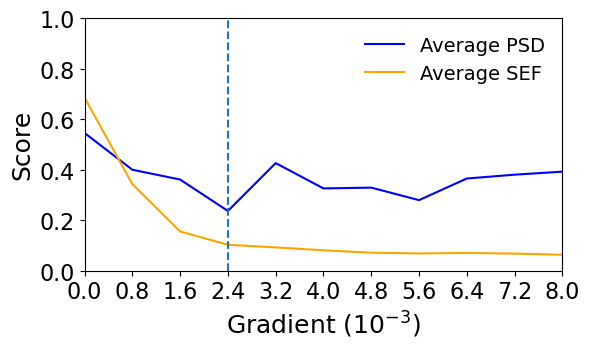

In [134]:
ngrad = 11
plt.figure(figsize = (6,3.6))
xvals = np.linspace(0,0.4,ngrad)/50
plt.plot(xvals,PSD_lev,"blue", label = "Average PSD")
plt.plot(xvals,ent_lev,"orange", label = "Average SEF")
plt.legend(fontsize = 14, frameon = False)
plt.xlim(0,0.4/50)
plt.ylim(0,1)
plt.xlabel(r"Gradient $(10^{-3})$",fontsize = 18)
plt.ylabel("Score",fontsize = 18)
plt.xticks(ticks = xvals, labels = np.round(np.multiply(xvals,1000),1),fontsize =16)
plt.yticks(fontsize =16)
plt.axvline(0.12/50, linestyle = "--")
plt.tight_layout()
plt.savefig("Images_for_paper/supp_fig5")


# Figure 5 B,C,D,E,F

In [179]:
ngrad = 5
cent_cycs = [[8.277605748580367, 31.98994957390635]] * 8
k1s = [9.72248548219913] * 8
k2s = [27.203267784255218] * 8

for s in range(ngrad):
    #linear
    C0 = 0.12
    print(C0)
    width, height = 50, 50
    x = ((np.arange(width))/50)[::-1]
    gradient_1D = C0 *x  
    gradient_2D = np.tile(gradient_1D, (height, 1))
    param_tris = list(zip(cent_cycs, k1s, k2s,gradient_2D*8))
    
    results_all = Parallel(n_jobs=8)(
            delayed(run_simulation_combo)(cent_c, k1, k2,FF_data_lst)
            for cent_c, k1, k2, FF_data_lst in param_tris
    ) 
    for i, results in enumerate(results_all):
        print(f"Saving simulation {i}")
        k1_values = [res['k1'] for res in results]
        k2_values = [res['k2'] for res in results]
        u_values = [res['u'] for res in results]
        v_values = [res['v'] for res in results]
        u2_values = [res['u2'] for res in results]
        v2_values = [res['v2'] for res in results]
        t_values = [res['t'] for res in results]
        np.savez(f"fig5_data_2/main_C0_{np.round(C0,3)}_{i+8*s}.npz", k1=k1_values, k2=k2_values, u=u_values, v=v_values, u2 = u2_values, v2 = v2_values, t=t_values)
        i += 1


0.12
Saving simulation 0
Saving simulation 1
Saving simulation 2
Saving simulation 3
Saving simulation 4
Saving simulation 5
Saving simulation 6
Saving simulation 7
0.12
Saving simulation 0
Saving simulation 1
Saving simulation 2
Saving simulation 3
Saving simulation 4
Saving simulation 5
Saving simulation 6
Saving simulation 7
0.12
Saving simulation 0
Saving simulation 1
Saving simulation 2
Saving simulation 3
Saving simulation 4
Saving simulation 5
Saving simulation 6
Saving simulation 7
0.12
Saving simulation 0
Saving simulation 1
Saving simulation 2
Saving simulation 3
Saving simulation 4
Saving simulation 5
Saving simulation 6
Saving simulation 7
0.12
Saving simulation 0
Saving simulation 1
Saving simulation 2
Saving simulation 3
Saving simulation 4
Saving simulation 5
Saving simulation 6
Saving simulation 7


In [181]:
ngrad = 40
ent_list = []
res_dict = {i: [] for i in range(0,ngrad)}
for s in range(int(ngrad/8)):
    print(s)
    for i in range(0,8):
        res = np.load(f"fig5_data_2/main_C0_{np.round(C0,3)}_{i+8*s}.npz")
        entropy_list = []
        xent = []
        for o in range(0,len(res['k1'])):
            FS1 = np.fft.fft2(res['u'][o], (50, 50))
            power_spectrum = np.abs(FS1)**2
            power_spectrum_normS1 = power_spectrum / np.sum(power_spectrum)
            entropy_list.append(-np.sum(power_spectrum_normS1 * np.log2(power_spectrum_normS1+ 0.00000000000000001)))
        ent_list.append(entropy_list)
        res_dict[i+8*s].append(res)
avg_res_sd4 = []
for i in range(0,len(res['k1'])):
    temp_mat = []
    for j in range(0,ngrad):
        temp_mat.append(res_dict[j][0]['u'][i])
    stacked = np.stack(temp_mat, axis=0)  # Shape will be (3, 50, 50)
    avg_res_sd4.append(np.mean(np.std(stacked[:, :, :], axis=0,ddof = 1)))
    

0
1
2
3
4


In [182]:
with open("fig5_noised_together_null.pkl", "wb") as f:
    pickle.dump({'ent_list': ent_list,
                 'PSD': avg_res_sd4}, f)

In [183]:
ngrad = 40
ent_list = []
res_dict = {i: [] for i in range(0,ngrad)}
for s in range(int(ngrad/8)):
    print(s)
    for i in range(0,8):
        res = np.load(f"fig5_data_2/main_C0_{np.round(C0,3)}_{i+8*s}.npz")
        entropy_list = []
        xent = []
        for o in range(0,len(res['k1'])):
            FS1 = np.fft.fft2(res['u2'][o], (50, 50))
            power_spectrum = np.abs(FS1)**2
            power_spectrum_normS1 = power_spectrum / np.sum(power_spectrum)
            entropy_list.append(-np.sum(power_spectrum_normS1 * np.log2(power_spectrum_normS1+ 0.00000000000000001)))
        ent_list.append(entropy_list)
        res_dict[i+8*s].append(res)
avg_res_sd4 = []
for i in range(0,len(res['k1'])):
    temp_mat = []
    for j in range(0,ngrad):
        temp_mat.append(res_dict[j][0]['u2'][i])
    stacked = np.stack(temp_mat, axis=0)  # Shape will be (3, 50, 50)
    avg_res_sd4.append(np.mean(np.std(stacked[:, :, :], axis=0,ddof = 1)))

0
1
2
3
4


In [184]:

with open("fig5_noised_together_FF.pkl", "wb") as f:
    pickle.dump({'ent_list': ent_list,
                 'PSD': avg_res_sd4}, f)


In [ ]:
with open("fig5_noised_together_null.pkl", "rb") as f:
    data = pickle.load(f)

ent_list_null = data['ent_list']
PSD_null = data['PSD']

with open("fig5_noised_together_FF.pkl", "rb") as f:
    data = pickle.load(f)

ent_list_FF = data['ent_list']
PSD_FF = data['PSD']

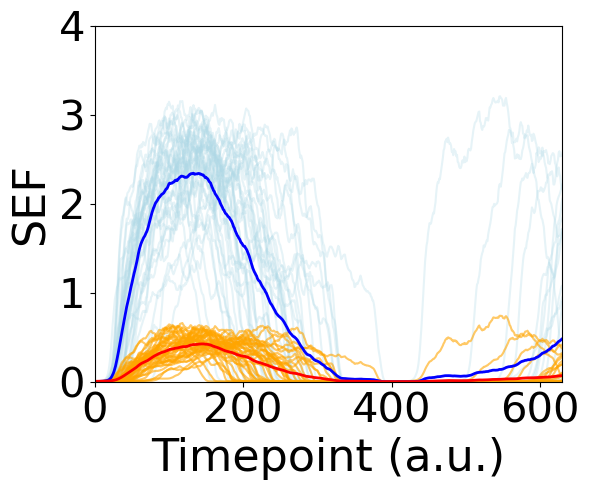

In [187]:
num_samp = 40
plt.figure(figsize=(6, 5))
for i in range(num_samp):
    plt.plot(ent_list_null[i], alpha = 0.3, color = 'lightblue')
for i in range(num_samp):
    plt.plot(ent_list_FF[i], alpha = 0.6, color = 'orange')
ent_null_mean = []
for i in range(len(ent_list_null[0])):
    ent_nulls = []
    for j in range(num_samp):
        ent_nulls.append(ent_list_null[j][i])
    ent_null_mean.append(np.mean(ent_nulls))
plt.plot(ent_null_mean, linewidth = 2, color = 'blue')
ent_FF_mean = []
for i in range(len(ent_list_FF[0])):
    ent_FFs = []
    for j in range(num_samp):
        ent_FFs.append(ent_list_FF[j][i])
    ent_FF_mean.append(np.mean(ent_FFs))

plt.plot(ent_FF_mean, linewidth = 2, color = 'red')
plt.xlabel("Timepoint (a.u.)",fontsize = 32)
plt.ylabel("SEF",fontsize = 32)
plt.xlim(0,630)
plt.ylim(0,4)
plt.xticks(ticks = [0,200,400,600], labels = [0,200,400,600],fontsize=30)
plt.yticks(ticks = [0,1,2,3,4],fontsize=30)
plt.tight_layout()
plt.savefig("Images_for_paper/fig5_SEF.png")
plt.show()

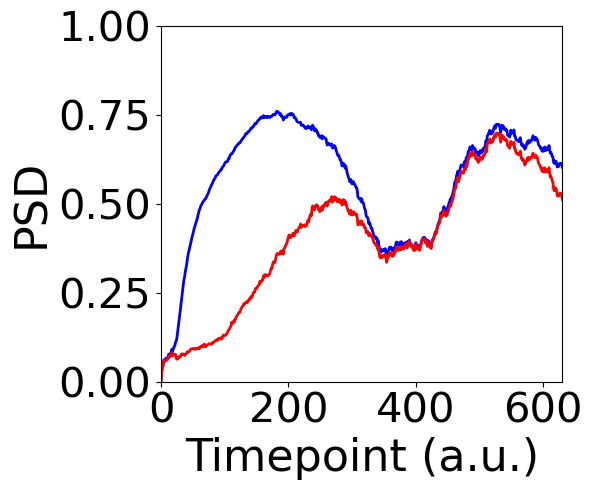

In [247]:
plt.figure(figsize=(6, 5))

plt.plot(PSD_null, linewidth = 2, color = 'blue')

plt.plot(PSD_FF, linewidth = 2, color = 'red')
plt.xlabel("Timepoint (a.u.)",fontsize = 32)
plt.ylabel("PSD",fontsize = 32)

plt.xticks(ticks = [0,200,400,600], labels = [0,200,400,600],fontsize=30)
plt.ylim(0,1)
plt.xticks(fontsize=30)
plt.xlim(0,630)

plt.yticks(ticks = [0,0.25,0.5,0.75,1],fontsize=30)
plt.tight_layout()
plt.savefig("Images_for_paper/fig5_PSD.png")
plt.show()


[101 102 100 103 109 108 115 106 117 110 116 105 107 104  96  99 118 120
 119 113 114 112 121 123  94  97 143 124 140 136 122 133 135  98 137 138
  95 111 141 134]


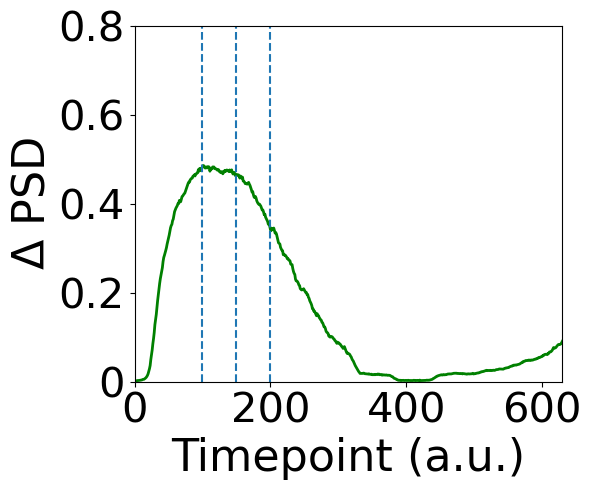

[  0   1   3   2 413 407 393   5 410   4 401 409 397   6 408 406 404 405
 398 402 391 399   7 394 395 400 412 396 389 411   8 403 390 392 388   9
  10  11 387 386  12  13  14 385  15 384 383  16 382  17 381 380 379  18
 378 377  19 376 373 375 374 372 369 364 366 370 371 368 367 351 354 365
 361 362 352 357 363 350 348 356 353 355 347 359 346 349 360 344 358 343
 341 342 345  20 340 339 333 335 334 332 336 338 337 331 330  21 329 328
  22 327 326 325  23 324 323 322 321  24 320 319 318  25 317 316 315 313
 314 312 311  26 310 307 308 306 309 305 304 303 302  27 298 301 300 297
 299 296 295 294 293  28 292 288 290 291 289 286 287 285 284  29 283 282
 281 280 279 278  30 277 276 275 274  31 273 272 268 271 270  32 267 269
 266 264 265 263 262  33 261 260 259 258  34 257 256  35 255 254 252 253
 251 250 246 248 245 247 249 244  36 243 242  37 241 240 239 238 237  38
  39 236 235 234  40 233  41 232 231 230  42 229 228 227 225 226  43 224
 223  44 221 222 219 220  45 218  46 217 216  47 21

In [28]:
plt.figure(figsize=(6, 5))
PSD_diff = np.subtract(PSD_null,PSD_FF)
plt.plot(PSD_diff, linewidth = 2, color = 'green')
plt.xlabel("Timepoint (a.u.)",fontsize = 32)
plt.ylabel(r"$\Delta$ PSD",fontsize = 32)
plt.xlim(0,630)
plt.ylim(0,0.8)
arr = np.array(PSD_diff[:414])

top2_indices = arr.argsort()[-40:][::-1]  # indices of top 2 elements
print(top2_indices)
plt.yticks(fontsize=30)
plt.axvline(100,linestyle = "--")
plt.axvline(150,linestyle = "--")

plt.xticks(ticks = [0,200,400,600], labels = [0,200,400,600],fontsize=30)

plt.yticks(ticks = [0,0.2,0.4,0.6,0.8], labels = [0,0.2,0.4,0.6,0.8],fontsize=30)
plt.axvline(200,linestyle = "--")
plt.tight_layout()
plt.savefig("Images_for_paper/fig5_PSD_imp.png")
plt.show()

top2_indices = arr.argsort()[:-40][::1]  
print(top2_indices)


In [32]:
ncols = len(timepoints)
nrows = 2  # first row = u, second row = u2
vmin_global = 0
vmax_global = 1
timepoints = [0,100,150,200]
# Load data
res_dict = {i: [] for i in range(40)}
for i in range(40):
    res = np.load(f"fig5_data_2/main_C0_0.12_{i}.npz")
    res_dict[i].append(res)

# Prepare PSD images
PSD_imgs = []
for key in ['u', 'u2']:
    PSD_img_row = []
    for t_idx, t in enumerate(timepoints):
        temp_mat = []
        for j in range(40):
            temp_mat.append(res_dict[j][0][key][t])
        stacked = np.stack(temp_mat, axis=0)
        PSD_img_row.append(np.std(stacked, axis=0,ddof = 1))
    PSD_imgs.append(PSD_img_row)  # PSD_imgs[0] = u, PSD_imgs[1] = u2

# Create figure


/var/tmp/pbs.1229547.pbs-7/ipykernel_1569326/1854344036.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


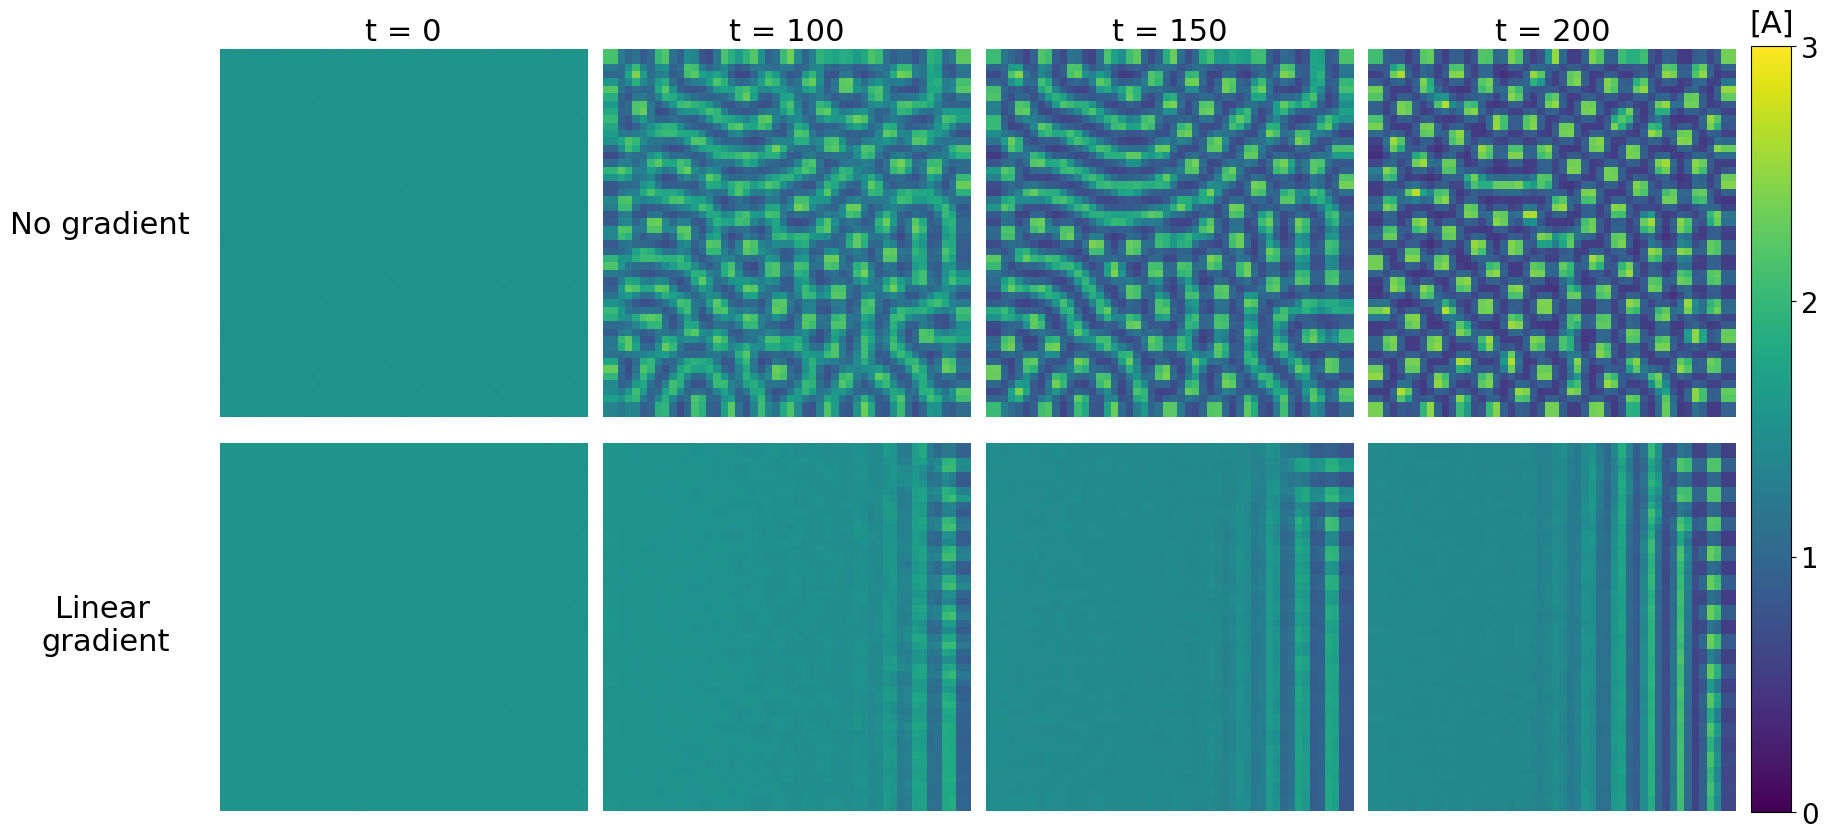

In [39]:
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(nrows, ncols + 1, width_ratios=[1]*ncols + [0.05], wspace=0.05, hspace=0.05)
run = 9
res = np.load(f"fig5_data_2/main_C0_0.12_{run}.npz")  
vmin_global = 0
vmax_global = 3
for row in range(nrows):
    for col in range(ncols):
        ax = fig.add_subplot(gs[row, col])
        if row ==0:
            im = ax.imshow(res['u'][timepoints[col]], vmin=vmin_global, vmax=vmax_global, cmap='viridis')
        else:
            im = ax.imshow(res['u2'][timepoints[col]], vmin=vmin_global, vmax=vmax_global, cmap='viridis')
        ax.axis('off')
        if row == 0:
            ax.set_title(f"t = {timepoints[col]}", fontsize=22)
        ax.set_aspect('equal')

cax = fig.add_subplot(gs[:, -1])  # span all rows
pos = cax.get_position()
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
ticks = np.arange(0, 3.1, 1)
cbar.set_ticks(ticks)
cbar.ax.tick_params(labelsize=20)
cax.set_position([pos.x0, pos.y0+0.003, 0.02, pos.height * 0.995])
# Label above the colorbar
cbar.ax.text(
    0.5, 1.01, "[A]", transform=cbar.ax.transAxes, fontsize=22,
    ha='center', va='bottom', rotation=0
)
row_labels = ["Linear  \ngradient", "No gradient"]  # adjust for nrows
for i, label in enumerate(row_labels):
    # y-coordinates: center of each row, distribute evenly
    y = [0.3,0.7]
    x = [0.1,0.11]
    fig.text(x[i], y[i], label, fontsize=22, va='center', ha='right', rotation=0)


plt.tight_layout()
plt.savefig("Images_for_paper/fig5_img2x4.png")
plt.show()

/var/tmp/pbs.1229547.pbs-7/ipykernel_1569326/2465118999.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


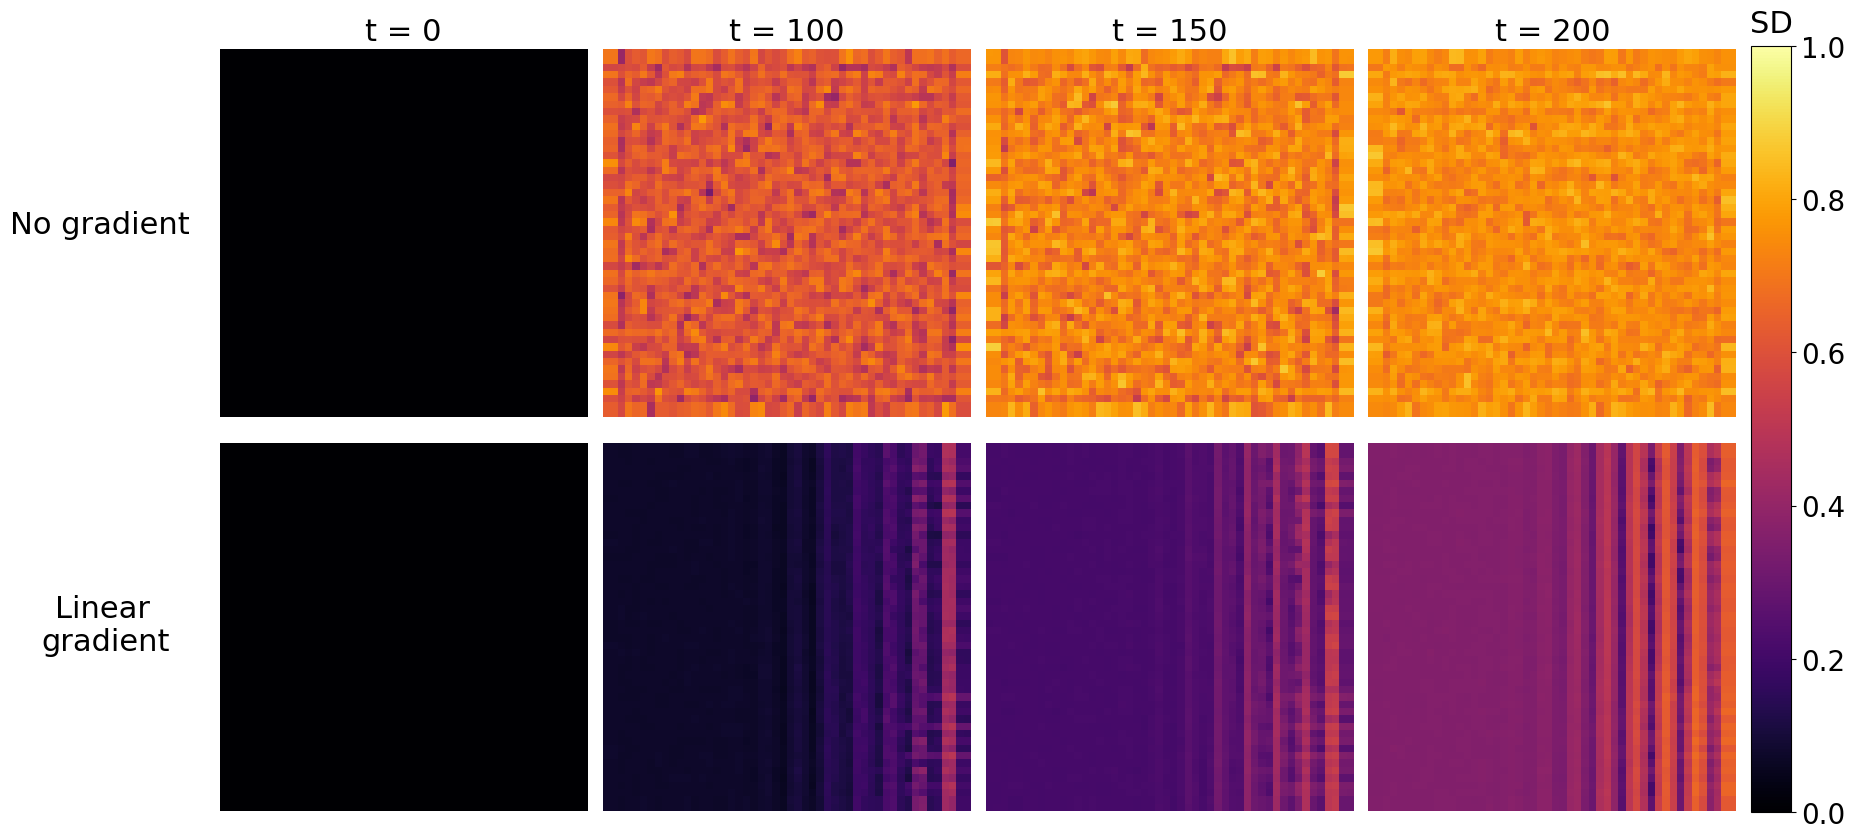

In [42]:
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(nrows, ncols + 1, width_ratios=[1]*ncols + [0.05], wspace=0.05, hspace=0.05)
vmax_global = 1
# Plot images
for row in range(nrows):
    for col in range(ncols):
        ax = fig.add_subplot(gs[row, col])
        im = ax.imshow(PSD_imgs[row][col], vmin=vmin_global, vmax=vmax_global, cmap='inferno')
        ax.axis('off')
        if row == 0:
            ax.set_title(f"t = {timepoints[col]}", fontsize=22)
        ax.set_aspect('equal')

cax = fig.add_subplot(gs[:, -1])  # span all rows
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
ticks = np.arange(0, 1.1, 0.2)
cbar.set_ticks(ticks)
cbar.ax.tick_params(labelsize=20)
cax.set_position([pos.x0, pos.y0+0.003, 0.02, pos.height * 0.995])
# Label above the colorbar
cbar.ax.text(
    0.5, 1.01, "SD", transform=cbar.ax.transAxes, fontsize=22,
    ha='center', va='bottom', rotation=0
)
row_labels = ["Linear  \ngradient", "No gradient"]  # adjust for nrows
for i, label in enumerate(row_labels):
    # y-coordinates: center of each row, distribute evenly
    y = [0.3,0.7]
    x = [0.1,0.11]
    fig.text(x[i], y[i], label, fontsize=22, va='center', ha='right', rotation=0)


plt.tight_layout()
plt.savefig("Images_for_paper/fig5_PSD_2x4.png")
plt.show()